# Conditional Probability (Discrete)

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** You've already spent some time conducting a preliminary exploratory data analysis (EDA) of IHH's ER data. You noticed that considering variables separately can result in misleading information. As such, today you will continue your EDA, this time also considering the *relationship between variables*. For example, you may want to know:

* Are there certain conditions that are more likely to occur on certain days?
* What makes a patient likely to need hospitalization?

**Challenge:** So far, however, we've only seen ways of characterizing the variability/stochasticity of a univariate random phenomenon independently of other variables. So how can we consider the relationship between variables? Answer: conditional probability. 

**Outline:** 
1. Introduce and practice the concepts, terminology, and notation behind discrete conditional probability distributions (leaving continuous distributions to a later time).
2. Answer the above questions using this new toolset.

Before getting started, let's load in our IHH ER data:

In [2]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-ER.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Day-of-Week,Condition,Hospitalized,Antibiotics,Knots
Patient ID,,,,,
9394,Friday,Allergic Reaction,No,No,0
898,Sunday,Allergic Reaction,Yes,Yes,0
2398,Saturday,Entangled Antennas,No,No,3
5906,Saturday,Allergic Reaction,No,No,0
2343,Monday,High Fever,Yes,No,0
8225,Thursday,High Fever,Yes,No,0
5506,Tuesday,High Fever,No,No,0
6451,Thursday,Allergic Reaction,No,No,0
2670,Sunday,Intoxication,No,No,0


## Terminology and Notation

As with (non-conditional) discrete probability, the statistical language---terminology and notation---we introduce here will allow us to precisely specify to a computer how to model our data. In the future, we will translate statements in this language directly into code that a computer can run.

**Concept.** Conditional probabilities allow us to ask questions of the form, "given that $A$ is true, what's the probability of $B$?". Although simple, this idea is actually quite powerful; all *predictive models* you may have heard of (e.g. regression, classification, etc.) are formulated using *conditional distributions*. To see what we mean, let's start with an example.

**Example.** Suppose you're working at the IHH ER, and you want to *predict* what is the probability that the next patient comes in with `Condition == "Intoxication"`. Given previously collected data, you can estimate this probability by counting the number of patients for which `Condition == "Intoxication"` and dividing by the total number of patients:
\begin{align}
\text{Probability of intoxication} = \frac{\text{Number of patients with intoxication}}{\text{Total number of patients}}
\end{align}

We'll call this probability the "naive predictor." Now, let's compute this naive predictor on our IHH ER data:

In [3]:
num_intoxicated = len(data[data['Condition'] == 'Intoxication'])
num_total = len(data)
naive_probability_of_intoxication = num_intoxicated / float(num_total)

print('Portion with Intoxication (Naive Predictor) =', round(naive_probability_of_intoxication, 3))

Portion with Intoxication (Naive Predictor) = 0.171


However, you also know that even in far reaches of the outer universe, beings work Mondays through Fridays, taking Saturdays and Sundays off. Therefore, you suspect intoxication may be more likely to occur on weekends. You decide to check whether your intuition is true here. If it's true, will you improve your ability to predict how likely the next patient is to come with intoxication?

We can modify the naive predictor above as follows to condition on the day of the week:
\begin{align}
\text{Probability of intoxication given day $d$} = \frac{\text{Number of patients with intoxication on day $d$}}{\text{Total number of patients on day $d$}}
\end{align}

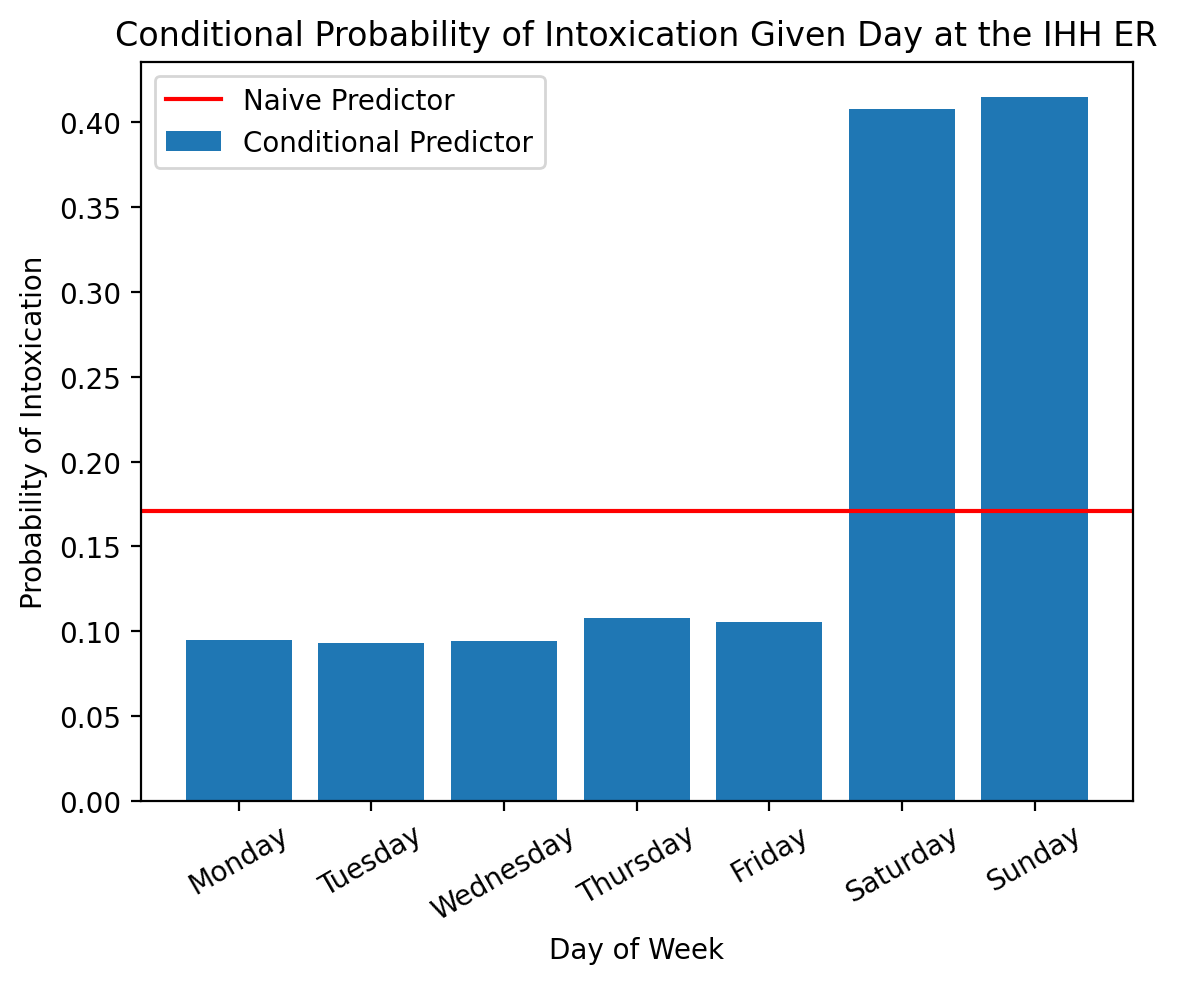

In [4]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

probabilities = []

# Iterate over the days of the week
for day in days_of_week:
    # Select all patients that came in on the specific day of the week
    patients_on_day = data[(data['Day-of-Week'] == day)]

    # Of the selected patients, further select patients with intoxication
    patient_intoxicated_on_day = patients_on_day[patients_on_day['Condition'] == 'Intoxication']

    # Compute the portion of patients with intoxication on this day
    portion_intoxicated_on_day = float(len(patient_intoxicated_on_day)) / float(len(patients_on_day))

    probabilities.append(portion_intoxicated_on_day)

# Plot!
plt.bar(days_of_week, probabilities, label='Conditional Predictor')
plt.axhline(naive_probability_of_intoxication, color='red', label='Naive Predictor')

# Add axis labels and titles
plt.xticks(rotation=30)
plt.xlabel('Day of Week')
plt.ylabel('Probability of Intoxication')
plt.title('Conditional Probability of Intoxication Given Day at the IHH ER')
plt.legend()
plt.show()

As you can see, the probability of a patient arriving with intoxication changes *significantly* from the naive predictor (above) if we consider the day of the week. Specifically, the above plot shows us that our naive predictor
1. significantly *over-estimates* the probability of intoxication on weekdays, and
2. significantly *under-estimates* the probability of intoxication on weekends.

Using a conditional distribution, we can leverage additional information (day of the week) to improve our prediction!

**Definition and Notation:** A conditional probability is a probability distribution that changes as a function of another random variable. 

> Continuing with the above example, 
> * Let $D$ denote the day of the week.
> * Let $I$ denote whether the patient arrives with intoxication.
> 
> Here, $p_I(\cdot)$ describes the (non-conditional) probability that a patient arrives with intoxication. It represents our *naive*, inaccurate prediction. In contrast, $p_{I | D}(\cdot | d)$ describes the *conditional* probability of "intoxication given the day"---the probability of intoxication changes from weekdays to weekends. In this notation, what comes on the right side of the vertical line is the "condition" (here, $D = d$).

**Sample Space or Support:** Since a discrete conditional distribution is still a discrete distribution, all notation/terminology from discrete probability still holds. 

> For our running example, the sample space is that of variable to the left of the line, $I$. That is, the sample space of $p_{I | D}(\cdot | d)$ is $I \in \{ 0, 1 \}$ (with 1 means intoxicated and 0 means not intoxicated). 

**Probability Mass Function (PMF):** The PMF is, again, that of the variable to the left of the vertical line. What makes a conditional probability different from a non-conditional distribution, however, is that the parameter of the distribution is now a *function of the condition*.
> In our example, the PMF is that of a Bernoulli random variable (since $I$ can only take on two values). Since it's a *conditional* distribution, it's parameter depends on the condition (the day $D = d$). We can write this as follows:
> \begin{align}
p_{I | D}(\cdot | d) = \mathrm{Ber}(\rho(d)),
\end{align}
> where
> \begin{align}
p_{I | D}(i | d) = \underbrace{\rho(d)^{i} \cdot \left(1 - \rho(d) \right)^{1 - i}}_{\text{Bernoulli PMF (see Wikipedia)}},
\end{align}
> and where
> \begin{align} \rho(d) &= \begin{cases}
0.1 & \text{if $d$ is weekday} \\
0.4 & \text{if $d$ is weekend} 
\end{cases} 
\end{align}
> In a sense, a conditional probability is the "if/else-expression of probability."

**Independent, Identically Distributed (i.i.d):** Just as before, a variable can be sampled i.i.d from a distribution.

> Given $D = d$, we write that $I$ is sampled i.i.d from the conditional as follows: $I | d \sim p_{I | D}(\cdot | d)$. This means that, given the day (e.g. $d = \mathrm{Monday}$), observing one patient with intoxication tells us nothing about the probability of observing another patient with intoxication. Note that without conditioning on the day, this is not true: observing many patients with intoxication could tell us that the current day is on a weekend, which means the probability of intoxication is higher overall.

**Summary of Notation:**
* Let $R$ and $C$ denote two RVs. 
* $R | c$ is then an RV describing "$R$ given $C = c$".
* $p_{R | C}(r | c)$ is the evaluation of the conditional PMF at $r$: i.e. given that $C = c$, what's the probability that $R = r$?
* $p_{R | C}(\cdot | c)$ is the conditional PMF of $R | c$. The dot represents the fact that we're representing the *whole* distribution---we haven't yet ask about the probability of $R = r$ as above.
* $R | c \sim p_{R | C}(\cdot | c)$ denotes that $R | c$ is sampled i.i.d. from $p_{R | C}(\cdot | c)$

```{admonition} Exercise: Fit conditional distributions by hand
Let us define the following RVs:
* $D$: Day-of-Week	
* $C$: Condition	
* $H$: Hospitalized	
* $A$: Antibiotics
* $K$: Knots

Our goal is to learn the distributions of the following conditional RVs:
1. $C | D$
2. $H | C$
3. $K | C$
4. $A | C, H$ (here, we condition on *two* RVs)

Each one of these conditional distributions represents a *predictive model*. For example, (1) says "given that the day is $D = d$, predict how likely is a patient to arrive with condition $C =c$"? 

**Part 1:** By exploring the data (as we did in the above example for "intoxication given day"), empirically estimate each conditional distribution above. When we say, "estimate the conditional distribution," we mean you estimate the distribution for every condition; for example, for $C | D$, we want you to empirically estimate $C | D$ for *every* $D = d$. Use the notation we introduced to write your answer. Don't forget to show your work with all the plots you generate!

**Part 2:** Compare each conditional distribution with its corresponding non-conditional version (these are called *marginals*) from before. What differences do you notice? How can the differences mislead the IHH ER?
```

## Getting Familiar with Distributions in `NumPyro`

Now that we've learned some conditional distributions by hand, we'll introduce the framework we'll use to implement our ML models: `NumPyro`. And specifically, we'll introduce one of the main building blocks in `NumPyro`: distributions.

**What is `NumPyro`?** `NumPyro` is a "Probabilistic Programming Language" based in `Jax`. It provides an interface for (nearly) direct translation of the stats/math we wrote above into code that we can use to fit to data, make predictions, and more. This will allow us to focus on the conceptual ideas behind probabilistic ML. 

**Instantiating Distributions in `NumPyro`.** `NumPyro` comes with many distributions already implemented. For a complete list of all available discrete distributions, check out the [this part of the documentation](https://num.pyro.ai/en/stable/distributions.html#discrete-distributions). So why use `NumPyro` instead of implementing the distributions on our own? It's easy to write subtle bugs that are hard to catch when implementing mathematical formulas in code. Also, using `NumPyro`'s distributions will help us highlight the overall *logic* of the code, instead of getting bogged down by the mathematical details. 

Distributions in `NumPyro` have several notable properties and methods we will rely on. Let's explore them together. First, we import the necessary components of `NumPyro`:

In [5]:
import jax.numpy as jnp
import jax.random as jrandom
import numpyro
import numpyro.distributions as D

Now, let's instantiate the simplest discrete distribution we know, the Bernoulli distribution, to describe the naive predictor from earlier.
\begin{align}
p_I(i) &= \mathrm{Ber}(\rho) = \rho^i \cdot (1 - \rho)^{1 - i}
\end{align}
Recall that a Bernoulli distribution takes in just one parameter, $\rho \in [0, 1]$, which determines the probability of sampling $I = 1$ vs. $I = 0$ (or Yes vs. No). Here let's instantiate the Bernoulli distribution with $\rho = 0.2$.

In [6]:
rho = jnp.array(0.2)
p_I = D.Bernoulli(rho)

That's it! 

**Evaluating the PMF of `NumPyro` Distributions.** Now, if we want to evaluate the PMF, $p_I(i)$, we can use `log_prob` method as follows (note that this returns the *log* of the PMF, so we'll have to exponentiate the result):

In [7]:
log_p_I_eq_1 = p_I.log_prob(jnp.array(1.0))
print('Probability of sampling a 1:', jnp.exp(log_p_I_eq_1))

log_p_I_eq_0 = p_I.log_prob(jnp.array(0.0))
print('Probability of sampling a 0:', jnp.exp(log_p_I_eq_0))

Probability of sampling a 1: 0.2
Probability of sampling a 0: 0.8


**Sampling from `NumPyro` Distributions.** `NumPyro` distributions all have a `sample` method which can be used to draw samples. It takes in two arguments:
1. A random number generator "key," which controls the randomness of the sample.
2. A shape, describing the number of i.i.d samples you want to draw.

Let's give it a go:

In [8]:
shape = (15,) # Shape of i.i.d samples we wish to draw 

key1 = jrandom.PRNGKey(seed=0) # Create a random number generator key
print('First batch drawn with key1: ', p_I.sample(key1, shape))
print('Second batch drawn with key1:', p_I.sample(key1, shape))

key2 = jrandom.PRNGKey(seed=1) # Create a random number generator key
print('Third batch drawn with key2: ', p_I.sample(key2, shape))

First batch drawn with key1:  [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
Second batch drawn with key1: [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
Third batch drawn with key2:  [0 1 1 0 0 0 0 0 0 1 0 1 0 1 1]


Notice in the above code, when using the same key twice (or the same `seed`), we get the *exact same batch of samples*. This is both a blessing and a curse. It's a blessing because this allows us to precisely control the randomness of our ML code. This will prove crucial for debugging later on. However, it can also be a curse if we accidentally use the same key in a place where we need two different sources of randomness.

**Best Practice: How to Manage Your Keys.** We will follow two rules of thumb:
1. Make only ONE CALL to `jrandom.PRNGKey` in your entire code.
2. Never use the same key twice.

But if we're restricting ourselves to only creating one key with `jrandom.PRNGKey`, how can we possibly call `sample` multiple times with different keys? `Jax` allows us to take a random key and split it into multiple different keys, each of which can be used for different purposes. This means we can create ONE KEY to control the randomness of our entire code. We can then split this key into multiple keys as needed. Here's how we can do this:

In [9]:
# Create ONE KEY to be used by your ENTIRE CODE
key = jrandom.PRNGKey(seed=0)

# Whenever you need to use the key for multiple purposes, split it into parts:
key_first, key_second, key_third = jrandom.split(key, 3) 

# Use a different key for each need
print('First batch drawn with key_first:  ', p_I.sample(key_first, shape))
print('Second batch drawn with key_second:', p_I.sample(key_second, shape))
print('Third batch drawn with key_third:  ', p_I.sample(key_third, shape))

First batch drawn with key_first:   [0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
Second batch drawn with key_second: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
Third batch drawn with key_third:   [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


**Conditional Distributions in `NumPyro`:** Now that we've implemented the naive predictor, let's implement our better predictor, $p_{I | D}(i | d)$. Recall the only difference between this predictor and the naive predictor is that the parameter of the distribution, $\rho$, now depends on the day, $d$.

In [10]:
def p_intoxication_given_day(day):
    '''
    Assume day is an integer from 0 to 6 (Monday to Sunday)
    '''    

    rho_given_d = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4])
    
    p_I_given_d = D.Bernoulli(rho_given_d[day])

    return p_I_given_d

# Example uses
p_I_given_Monday = p_intoxication_given_day(jnp.array(0))
p_I_given_Saturday = p_intoxication_given_day(jnp.array(5))

In the above, `p_I_given_Monday` and `p_I_given_Saturday` are just `NumPyro` Bernoulli distributions, so you can use their `log_prob` and `sample` functions just like before.

```{admonition} Exercise: Implement conditional distributions 

**Part 1:** Implement each one of the conditional distributions from the previous exercise in `NumPyro`, following the example of `p_intoxication_given_day` above. 

Note: `NumPyro` discrete distributions only work with integers, not strings. For example, instead of using $d = \text{Monday}$, you should convert the days of the week into integers from 0 to 6 (Monday to Sunday), and instead use $d = 0$ for "Monday". We've created two helper functions to help you with this conversion: `convert_day_of_week_to_int` and `convert_condition_to_int`. You can use them as follows:
  * `convert_day_of_week_to_int(data['Day-of-Week'])`
  * `convert_condition_to_int(data['Condition'])`

**Part 2:** Verify that your implementation is correct by sampling from each conditional distribution and eye-balling that the samples look correct. Be sure to follow the best practices above when using a random number generator key. 
```